**写在前面，这个卡有点水，还在努力推前面的基础算法模型公式中，后续继续完善吧~**

**案例：幸福感预测**  
### 背景

赛题使用公开数据的问卷调查结果，选取其中多组变量，包括个体变量（性别、年龄、地域、职业、健康、婚姻与政治面貌等等）、家庭变量（父母、配偶、子女、家庭资本等等）、社会态度（公平、信用、公共服务等等），来预测其对幸福感的评价。

幸福感预测的准确性不是赛题的唯一目的，更希望选手对变量间的关系、变量群的意义有所探索与收获。


### 数据信息
赛题要求使用以上 **139** 维的特征，使用 **8000** 余组数据进行对于个人幸福感的预测（预测值为1，2，3，4，5，其中1代表幸福感最低，5代表幸福感最高）。
因为考虑到变量个数较多，部分变量间关系复杂，数据分为完整版和精简版两类。可从精简版入手熟悉赛题后，使用完整版挖掘更多信息。在这里我直接使用了完整版的数据。赛题也给出了index文件中包含每个变量对应的问卷题目，以及变量取值的含义；survey文件中为原版问卷，作为补充以方便理解问题背景。

### 评价指标
最终的评价指标为均方误差MSE，即：
$$Score = \frac{1}{n} \sum_1 ^n (y_i - y ^*)^2$$


**导入数据**

In [2]:
import pandas as pd

In [57]:
FILE_PATH = "./datasets/happiness/"

train = pd.read_csv(FILE_PATH+'train.csv')
test = pd.read_csv(FILE_PATH+'test.csv')
# 删除标签类中的异常数据
train = train[train['happiness']!=-8].reset_index(drop=True)
target_col = "happiness" #目标列
target = train[target_col]
train_data_copy = train.copy()
del train_data_copy[target_col]
data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

In [64]:
index = pd.read_excel(FILE_PATH+'index.xlsx')

In [66]:
index

,变量名,原始问卷编号,问题,取值含义,精简版
0,-,-,通用含义,-1 = 不适用; -2 = 不知道; -3 = 拒绝回答; -8 = 无法回答;,NaN
1,id,-,编号,-,Y
2,survey_type,s1,样本类型,1 = 城市; 2 = 农村;,Y
3,province,s41,采访地点-省/自治区/直辖市编码,1 = 上海市; 2 = 云南省; 3 = 内蒙古自治区; 4 = 北京市; 5 = 吉林省; 6 = 四川省; 7 = 天津市; 8 = 宁夏回族自治区; 9 = 安徽省; 10 = 山东省...,Y
4,city,s42,采访地点-地级市编码,-,Y
5,county,s43,采访地点-县/区编码,-,Y
6,survey_time,a0,问卷当前时间,-,Y
7,gender,a2,您的性别,1 = 男; 2 = 女;,Y
8,birth,a301,您的出生日期-年,-,Y
9,nationality,a4,您的民族,1 = 汉; 2 = 蒙; 3 = 满; 4 = 回; 5 = 藏; 6 = 壮; 7 = 维; 8 = 其他;,Y


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Columns: 139 entries, id to public_service_9
dtypes: float64(26), int64(109), object(4)
memory usage: 11.6+ MB


In [18]:
train.happiness.value_counts()

4    4818
5    1410
3    1159
2     497
1     104
Name: happiness, dtype: int64

**数据预处理**

**填充缺失值**：在这里我采取的方式是将缺失值补全，使用fillna(value)，其中value的数值根据具体的情况来确定。例如将大部分缺失信息认为是零，将家庭成员数认为是1，将家庭收入这个特征认为是66365，即所有家庭的收入平均值。部分实现代码如下：

In [23]:
#填充缺失值 共25列 去掉4列 填充21列
#以下的列都是缺省的，视情况填补
data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

**处理与时间有关的信息**，这里主要分为两部分进行处理：首先是将“连续”的年龄，进行分层处理，即划分年龄段，具体地在这里我们将年龄分为了6个区间。其次是计算具体的年龄，在Excel表格中，只有出生年月以及调查时间等信息，我们根据此计算出每一位调查者的真实年龄。具体实现代码如下：

In [25]:
#144+1 =145
#继续进行特殊的列进行数据处理
#读happiness_index.xlsx
#防止时间格式不同的报错errors='coerce
data['survey_time'] = pd.to_datetime(data['survey_time'], \
                                     format='%Y-%m-%d',
                                     errors='coerce')
data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
data['age'] = data['survey_time']-data['birth']
# print(data['age'],data['survey_time'],data['birth'])
#年龄分层 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5]) 

在这里因为家庭的收入是连续值，所以不能再使用取众数的方法进行处理，这里就直接使用了均值进行缺失值的**补全**。第三种方法是使用我们日常生活中的真实情况，例如“宗教信息”特征为负数的认为是“不信仰宗教”，并认为“参加宗教活动的频率”为1，即没有参加过宗教活动，主观的进行补全，这也是我在这一步骤中使用最多的一种方式。就像我自己填表一样，这里我全部都使用了我自己的想法进行缺省值的补全。

In [26]:
#对‘宗教’处理
data.loc[data['religion']<0,'religion'] = 1 #1为不信仰宗教
data.loc[data['religion_freq']<0,'religion_freq'] = 1 #1为从来没有参加过
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4 #初中
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0 #认为无收入
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1 #认为是群众
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #个人的想法，哈哈哈，没有60斤的成年人吧
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4 #认为是比较健康
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3

使用**众数**（代码中使用mode()来实现异常值的修正），由于这里的特征是空闲活动，所以采用众数对于缺失值进行处理比较合理。具体的代码参考如下：

In [27]:
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = 2 #很少
data.loc[data['relax']<0,'relax'] = 4 #经常
data.loc[data['learn']<0,'learn'] = 1 #从不，哈哈哈哈
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4
#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2
#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

取**均值**进行缺失值的补全（代码实现为means()），在这里因为家庭的收入是连续值，所以不能再使用取众数的方法进行处理，这里就直接使用了均值进行缺失值的补全。具体的代码参考如下：

In [29]:
#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0 #变为0和1
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

#部分特征处理，取众数
for i in range(1,9+1):
#     print(data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)])
#     print(data['public_service_'+str(i)].dropna().mode().values)
    print(data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)])
    print(data['public_service_'+str(i)].dropna().mode().values)
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = int(data['public_service_'+str(i)].dropna().mode().values)
for i in range(1,13+1):
    print(data['trust_'+str(i)].dropna().mode().values)
    print(data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)])
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = int(data['trust_'+str(i)].dropna().mode().values)

14      -2
52      -2
112     -2
143     -2
158     -2
        ..
10808   -2
10836   -2
10858   -2
10873   -2
10942   -2
Name: public_service_1, Length: 316, dtype: int64
[80]
52      -2.0
112     -2.0
160     -2.0
203     -2.0
220     -3.0
        ... 
10796   -2.0
10808   -2.0
10836   -2.0
10858   -2.0
10942   -2.0
Name: public_service_2, Length: 230, dtype: float64
[80.]
26      -2
49      -2
50      -2
52      -2
54      -2
        ..
10810   -2
10858   -2
10859   -2
10942   -2
10943   -2
Name: public_service_3, Length: 586, dtype: int64
[80]
14      -2
52      -2
54      -2
71      -2
112     -2
        ..
10836   -2
10858   -2
10868   -2
10924   -2
10942   -2
Name: public_service_4, Length: 442, dtype: int64
[80]
14      -2.0
50      -2.0
52      -2.0
54      -2.0
98      -2.0
        ... 
10858   -2.0
10859   -2.0
10877   -2.0
10920   -2.0
10942   -2.0
Name: public_service_5, Length: 508, dtype: float64
[80.]
14      -2
52      -2
54      -2
112     -2
159     -2
        ..
1080

**数据增广**

这一步，我们需要进一步分析每一个特征之间的关系，从而进行数据增广。经过思考，这里我添加了如下的特征：第一次结婚年龄、最近结婚年龄、是否再婚、配偶年龄、配偶年龄差、各种收入比（与配偶之间的收入比、十年后预期收入与现在收入之比等等）、收入与住房面积比（其中也包括10年后期望收入等等各种情况）、社会阶级（10年后的社会阶级、14年后的社会阶级等等）、悠闲指数、满意指数、信任指数等等。除此之外，我还考虑了对于同一省、市、县进行了归一化。例如同一省市内的收入的平均值等以及一个个体相对于同省、市、县其他人的各个指标的情况。同时也考虑了对于同龄人之间的相互比较，即在同龄人中的收入情况、健康情况等等。具体的实现代码如下：

In [30]:
#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1) #同居伴侣
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

#county  mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

#age   mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])

经过如上的操作后，最终我们的特征从一开始的131维，扩充为了272维的特征。接下来考虑特征工程、训练模型以及模型融合的工作。

In [31]:
print('shape',data.shape)
data.head()

shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,1970,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.666638,0.925941
1,2,2,18,52,85,1970,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.130778,1.188442
2,3,2,29,83,126,1970,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.193204,0.803693
3,4,2,10,28,51,1970,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.153810,1.300950
4,5,1,7,18,36,1970,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.728161,1.117428


我们还应该**删去有效样本数很少**的特征，例如负值太多的特征或者是缺失值太多的特征，这里我一共删除了包括“目前的最高教育程度”在内的9类特征，得到了最终的263维的特征

In [32]:
#272-9=263
#删除数值特别少的和之前用过的特征
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True) #还是补0
train_shape = train.shape[0] #一共的数据量，训练集
features = data[use_feature].columns #删除后所有的特征
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape #最终一种263个特征

(7988, 263)

**这里选择了最重要的49个特征，作为除了以上263维特征外的另外一组特征**

In [33]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape #最重要的49个特征

(7988, 49)

选择需要进行onehot编码的离散变量进行**one-hot编码**，再合成为第三类特征，共383维。

In [52]:
from sklearn import preprocessing
import numpy as np


In [41]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] #已经是0、1的值不需要onehot
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape #变为onehot编码格式

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

基于此，我们构建完成了三种特征工程（训练数据集），其一是上面提取的最重要的49中特征，其中包括健康程度、社会阶级、在同龄人中的收入情况等等特征。其二是扩充后的263维特征（这里可以认为是初始特征）。其三是使用One-hot编码后的特征，这里要使用One-hot进行编码的原因在于，有部分特征为分离值，例如性别中男女，男为1，女为2，我们想使用One-hot将其变为男为0，女为1，来增强机器学习算法的鲁棒性能；再如民族这个特征，原本是1-56这56个数值，如果直接分类会让分类器的鲁棒性变差，所以使用One-hot编码将其变为6个特征进行非零即一的处理。

**特征建模**

**lightGBM**

首先我们对于原始的263维的特征，使用lightGBM进行处理，这里我们使用5折交叉验证的方法：

In [55]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
##### lgb_263 #
#lightGBM决策树
lgb_263_param = {
'num_leaves': 7, 
'min_data_in_leaf': 20, #叶子可能具有的最小记录数
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt", #用gbdt算法
"feature_fraction": 0.18, #例如 0.18时，意味着在每次迭代中随机选择18％的参数来建树
"bagging_freq": 1,
"bagging_fraction": 0.55, #每次迭代时用的数据比例
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   #交叉切分：5
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):

    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])#train:val=4:1

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))

fold n°1
Training until validation scores don't improve for 800 rounds
[500]	training's l2: 0.499759	valid_1's l2: 0.532511
[1000]	training's l2: 0.451534	valid_1's l2: 0.499139
[1500]	training's l2: 0.425469	valid_1's l2: 0.48537
[2000]	training's l2: 0.407403	valid_1's l2: 0.479239
[2500]	training's l2: 0.393014	valid_1's l2: 0.475614
[3000]	training's l2: 0.380793	valid_1's l2: 0.473785
[3500]	training's l2: 0.370059	valid_1's l2: 0.472695
[4000]	training's l2: 0.36028	valid_1's l2: 0.471758
[4500]	training's l2: 0.351301	valid_1's l2: 0.471068
[5000]	training's l2: 0.342893	valid_1's l2: 0.470821
[5500]	training's l2: 0.33497	valid_1's l2: 0.470361
[6000]	training's l2: 0.32745	valid_1's l2: 0.470349
[6500]	training's l2: 0.320181	valid_1's l2: 0.470308
[7000]	training's l2: 0.313344	valid_1's l2: 0.470202
[7500]	training's l2: 0.306777	valid_1's l2: 0.470197
[8000]	training's l2: 0.300353	valid_1's l2: 0.470162
Early stopping, best iteration is:
[7417]	training's l2: 0.307852	vali

接着，我使用已经训练完的lightGBM的模型进行特征重要性的判断以及可视化，从结果我们可以看出，排在重要性第一位的是**equity-公平性**，与我们主观的看法基本一致。

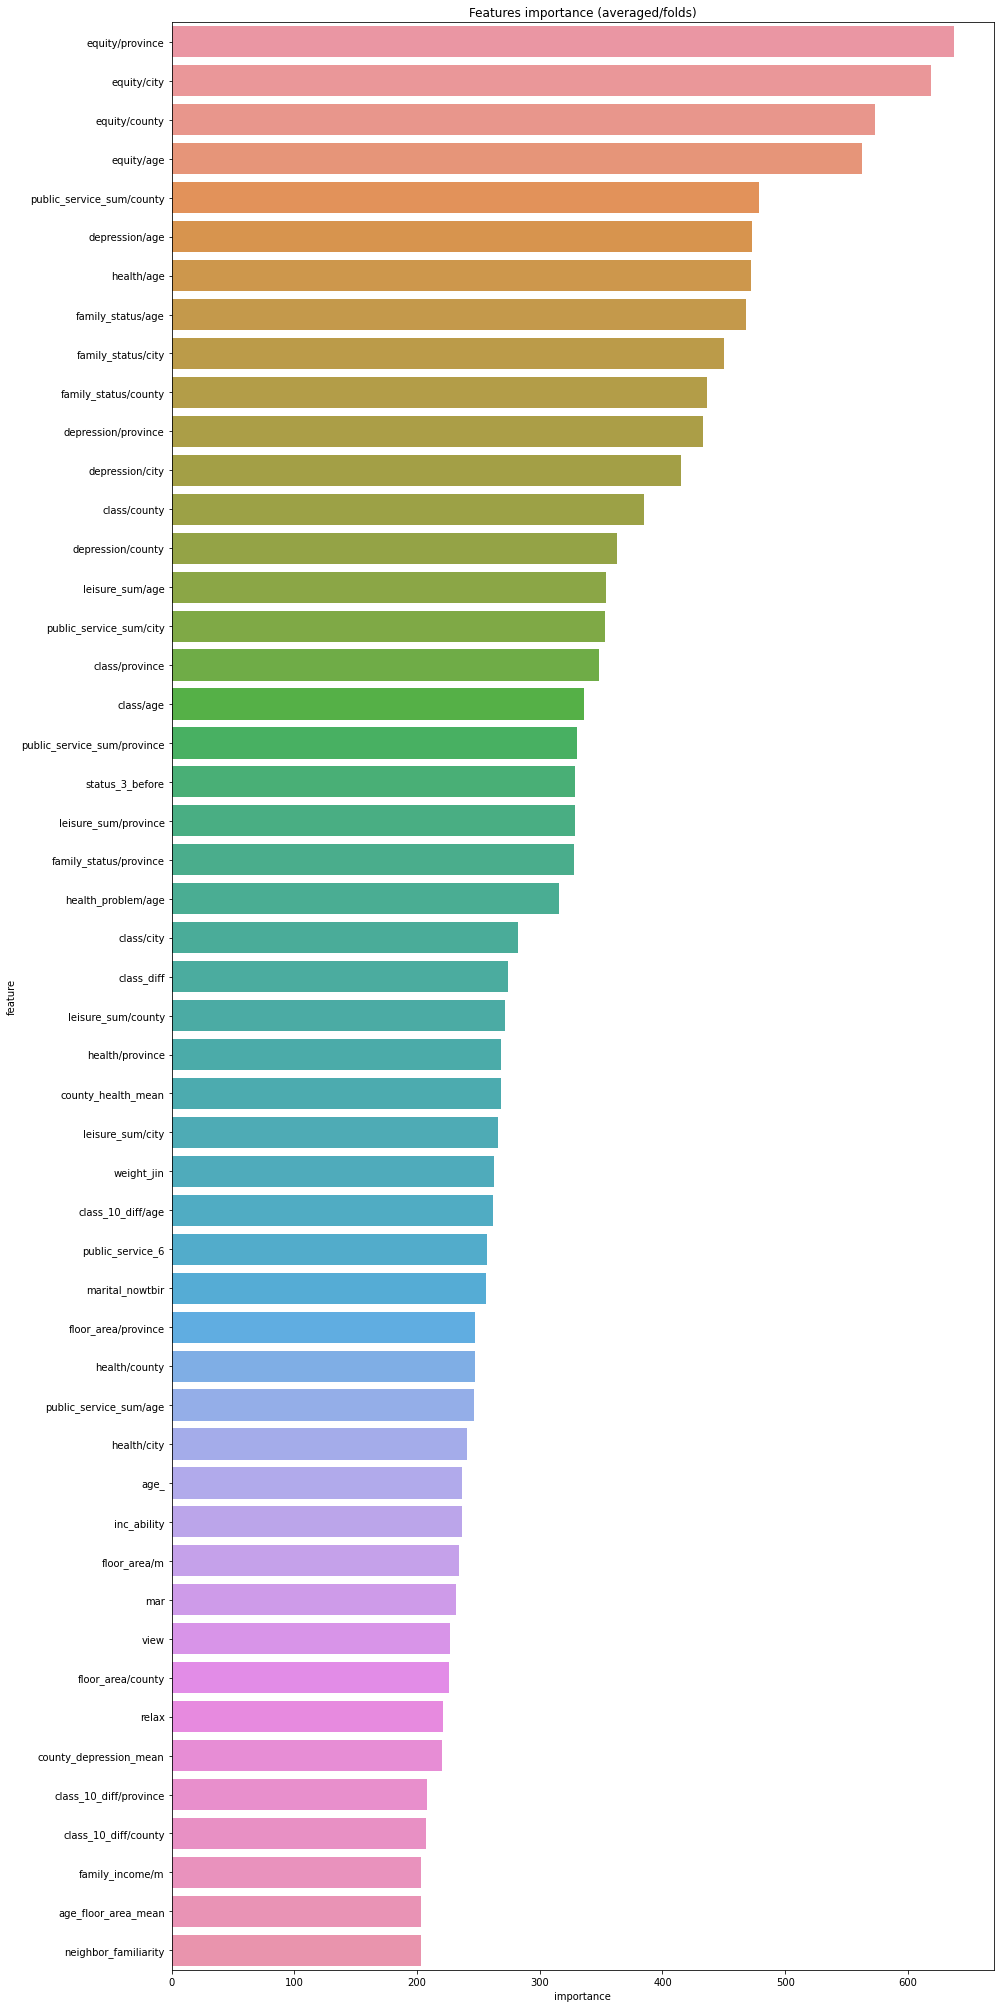

In [56]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])
df['importance']=list(lgb_263.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

**xgboost**

In [68]:
import xgboost as xgb

In [69]:
##### xgb_263
#xgboost
xgb_263_params = {'eta': 0.02,  #lr
              'max_depth': 6,  
              'min_child_weight':3,#最小叶子节点样本权重和
              'gamma':0, #指定节点分裂所需的最小损失函数下降值。
              'subsample': 0.7,  #控制对于每棵树，随机采样的比例
              'colsample_bytree': 0.3,  #用来控制每棵随机采样的列数的占比 (每一列是一个特征)。
              'lambda':2,
              'objective': 'reg:linear', 
              'eval_metric': 'rmse', 
              'silent': True, 
              'nthread': -1}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_263[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train_263[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_263_params)
    oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
    predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, target)))

fold n°1
[23:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.39998	valid_data-rmse:3.40012
[500]	train-rmse:0.40757	valid_data-rmse:0.68694
[1000]	train-rmse:0.27417	valid_data-rmse:0.68791
[1328]	train-rmse:0.21089	valid_data-rmse:0.68885
fold n°2
[23:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:17] WARNING: C:/Users/Administrator/wor

c:\python39\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[500]	train-rmse:0.41084	valid_data-rmse:0.67688
[1000]	train-rmse:0.27261	valid_data-rmse:0.67702
[1281]	train-rmse:0.21821	valid_data-rmse:0.67793
fold n°3
[23:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.40001	valid_data-rmse:3.40036
[500]	train-rmse:0.40785	valid_data-rmse:0.67237
[1000]	train-rmse:0.27420	valid_data-rmse:0.67408
[1158]	train-rmse:0.24095	valid_data-rmse:0.67426
fold n°4
[23:18:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release

**RandomForestRegressor随机森林**

In [76]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as rfr

In [77]:
#RandomForestRegressor随机森林
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_rfr_263 = np.zeros(len(X_train_263))
predictions_rfr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    rfr_263 = rfr(n_estimators=1600,max_depth=9, min_samples_leaf=9, min_weight_fraction_leaf=0.0,
            max_features=0.25,verbose=1,n_jobs=-1) #并行化
    #verbose = 0 为不在标准输出流输出日志信息
#verbose = 1 为输出进度条记录
#verbose = 2 为每个epoch输出一行记录
    rfr_263.fit(tr_x,tr_y)
    oof_rfr_263[val_idx] = rfr_263.predict(X_train_263[val_idx])
    
    predictions_rfr_263 += rfr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_rfr_263, target)))

fold n°1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    6.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

fold n°2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    6.5s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

fold n°3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    6.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

fold n°4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    6.9s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

fold n°5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    6.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

CV score: 0.60127692


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1600 out of 1600 | elapsed:    0.2s finished


**GradientBoostingRegressor梯度提升决策树**

In [79]:
from sklearn.ensemble import GradientBoostingClassifier as gbr

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
oof_gbr_263 = np.zeros(train_shape)
predictions_gbr_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_263[trn_idx]
    tr_y = y_train[trn_idx]
    gbr_263 = gbr(n_estimators=400, learning_rate=0.01,subsample=0.65,max_depth=7, min_samples_leaf=20,
            max_features=0.22,verbose=1)
    gbr_263.fit(tr_x,tr_y)
    oof_gbr_263[val_idx] = gbr_263.predict(X_train_263[val_idx])
    
    predictions_gbr_263 += gbr_263.predict(X_test_263) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_gbr_263, target)))

fold n°1
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1040           0.0046            1.27m
         2           1.1111           0.0041            1.26m
         3           1.0949           0.0036            1.26m
         4           1.0926           0.0042            1.25m
         5           1.0814           0.0037            1.25m
         6           1.0984           0.0034            1.24m
         7           1.0716           0.0033            1.24m
         8           1.0611           0.0036            1.24m
         9           1.0547           0.0032            1.23m
        10           1.0502           0.0030            1.24m
        20           1.0055           0.0022            1.21m
        30           0.9599           0.0015            1.17m
        40           0.9282           0.0013            1.14m
        50           0.8825           0.0011            1.10m
        60           0.8649           0.0007            1.07